In [1]:
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from lightgbm import LGBMRegressor, plot_importance
#from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler, PowerTransformer
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
#from mlxtend.regressor import StackingCVRegressor
from datetime import datetime

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
os.chdir('D:\\NIA\\선택과제\\2021년_미래기술_챌린지_211002\\1. 이커머스 FC주문 데이터')

df = pd.read_csv('df출고.csv')
df_abc = pd.read_csv('df_abc.csv')

C:\Users\tjddl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df출고 = df[['창고코드','고객사코드','품목코드','품목수량','권역구분','weekdays','holidays','date','month','day_of_month']]
df출고

,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month
0,KX007,90001443,5161917826,4,8,0,1,2021-03-01 00:00:00,3,1
1,KX007,90001341,598604962-4,1,3,0,1,2021-03-01 00:00:00,3,1
2,KX007,90001541,4861386623_4,1,41,0,1,2021-03-01 00:00:00,3,1
3,KX007,90001542,4884978039_1,1,21,0,1,2021-03-01 00:00:00,3,1
4,KX007,90001542,4977419343_1,1,3,0,1,2021-03-01 00:00:00,3,1
...,...,...,...,...,...,...,...,...,...,...
1496515,KX007,90001302,5526911305_28,1,21,2,0,2021-06-30 00:00:00,6,30
1496516,KX007,90001682,5048285001,1,21,2,0,2021-06-30 00:00:00,6,30
1496517,KX007,90001682,5417720634,1,21,2,0,2021-06-30 00:00:00,6,30
1496518,KX007,90001302,575871584,1,7,2,0,2021-06-30 00:00:00,6,30


### 관리 대상 고객사, 품목 및 변수 선별


* 품목코드 중 판매이력이 부족한 데이터 다수
* 각 품목코드의 주문이력에 대해 충분히 학습시켜 예측하기 위해 3,4,5,6달에 주문 내역이 모두 존재하는 품목코드만을 추출

In [4]:
all_3456 = pd.pivot_table(df출고,
                      index=['고객사코드','품목코드','권역구분'],
                      columns = 'month',
                      values = '품목수량',
                     aggfunc = 'sum').reset_index()

In [5]:
all_3456.dropna(axis = 0, how = 'any', inplace = True)
all_3456

month,고객사코드,품목코드,권역구분,3,4,5,6
122,90001302,120941953_3,10,9.0,1.0,1.0,1.0
124,90001302,120941953_3,12,3.0,2.0,3.0,1.0
125,90001302,120941953_3,13,3.0,2.0,1.0,1.0
129,90001302,120941953_3,17,1.0,6.0,1.0,2.0
130,90001302,120941953_3,18,3.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...
206197,90001582,4789343708_4,44,1.0,7.0,11.0,3.0
206199,90001582,4789343708_4,47,2.0,6.0,11.0,3.0
206210,90001582,4789343708_4,58,1.0,4.0,11.0,2.0
206225,90001582,4790583537_1,6,1.0,5.0,1.0,5.0


##### 3,4,5월만 뽑아내기

In [6]:
df_all = pd.merge(df출고, all_3456, on = ['고객사코드','품목코드','권역구분'])
df_all.head()

,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month,3,4,5,6
0,KX007,90001341,598604962-4,1,3,0,1,2021-03-01 00:00:00,3,1,22.0,38.0,27.0,25.0
1,KX007,90001341,598604962-4,1,3,0,1,2021-03-01 00:00:00,3,1,22.0,38.0,27.0,25.0
2,KX007,90001341,598604962-4,1,3,0,1,2021-03-01 00:00:00,3,1,22.0,38.0,27.0,25.0
3,KX007,90001341,598604962-4,1,3,0,1,2021-03-01 00:00:00,3,1,22.0,38.0,27.0,25.0
4,KX007,90001341,598604962-4,1,3,2,0,2021-03-03 00:00:00,3,3,22.0,38.0,27.0,25.0


In [7]:
df_345 = df_all[df_all.month != 6]

##### 필요한 변수만을 추출

In [8]:
df_abc1 = df_abc[['고객사코드','품목코드','권역구분','CV','TO%','ABC']]
df_abc1 = df_abc1.fillna(0)

df_abc1

,고객사코드,품목코드,권역구분,CV,TO%,ABC
0,90001441,4609081354_1,16,3.528975,0.100143,A
1,90001542,4658408144_1,16,0.359414,0.079963,A
2,90001542,4658408144_1,14,0.368315,0.074197,A
3,90001542,4658408144_1,10,0.345624,0.074045,A
4,90001441,4609081354_1,56,0.000000,0.069038,A
...,...,...,...,...,...,...
195670,90001302,4844159329,10,0.000000,0.000076,C
195671,90001302,4844159329,12,0.000000,0.000076,C
195672,90001302,4844159329,16,0.000000,0.000076,C
195673,90001302,4844158392,54,0.000000,0.000076,C


##### 3,4,5월 데이터 생성

In [9]:
df_345_new = pd.merge(df_345, df_abc1, on = ['고객사코드','품목코드','권역구분'] )
df_345_new.drop([3,4,5,6], axis = 1, inplace = True)

In [10]:
df_345_new.isna().sum()

창고코드            0
고객사코드           0
품목코드            0
품목수량            0
권역구분            0
weekdays        0
holidays        0
date            0
month           0
day_of_month    0
CV              0
TO%             0
ABC             0
dtype: int64

In [11]:
df_345_new['고객사코드'] = df_345_new['고객사코드'].astype('object')
df_345_new['품목코드'] = df_345_new['품목코드'].astype('object')
df_345_new['권역구분'] = df_345_new['권역구분'].astype('object')

In [12]:
import gc
gc.collect()

120

In [13]:
df_345_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406547 entries, 0 to 406546
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   창고코드          406547 non-null  object 
 1   고객사코드         406547 non-null  object 
 2   품목코드          406547 non-null  object 
 3   품목수량          406547 non-null  int64  
 4   권역구분          406547 non-null  object 
 5   weekdays      406547 non-null  int64  
 6   holidays      406547 non-null  int64  
 7   date          406547 non-null  object 
 8   month         406547 non-null  int64  
 9   day_of_month  406547 non-null  int64  
 10  CV            406547 non-null  float64
 11  TO%           406547 non-null  float64
 12  ABC           406547 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 43.4+ MB


### Anova검정을 통해 교호작용을 확인하여 범주형변수간의 관계를 파악
* 고객사코드, 품목코드, 권역구분별로 품목수량의 평균이 차이가 있다는 것을 검정

In [15]:
import random
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


r = random.sample(range(40000), 100)

model = ols('품목수량 ~ C(품목코드) * C(권역구분) * C(고객사코드) ', df_345_new.iloc[r]).fit()
anova_lm(model, typ = 3)


#주효과는 독립변수들이 각각 독립적으로 종속변수에 미치는 영향을 검정하는 것인데, 즉 한 처치변수의 변화가 결과변수에 미치는 영향을 말합니다.

#교호용효과는 독립변수들이 서로 연관되어 종속변수에 미치는 영향을 검정하는 것인데, 즉 다른 처치변수의 변화에 따라 한 처치변수가 결과변수에 미치는 영향에 관한 것입니다.

C:\Users\tjddl\anaconda3\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 990, but rank is 73
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 90, but rank is 25
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 99, but rank is 47
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2970, but rank is 64
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
Intercept,11.248819,1.0,155.233705,1.040653e-11
C(품목코드),16.023835,30.0,7.370964,2.970419e-06
C(권역구분),6.277312,33.0,2.625058,9.191738e-03
C(고객사코드),3.589195,3.0,16.510295,6.101876e-06
C(품목코드):C(권역구분),669.263592,990.0,9.329129,8.499541e-08
C(품목코드):C(고객사코드),52.759272,90.0,8.089755,1.793041e-06
C(권역구분):C(고객사코드),65.887652,99.0,9.184339,1.726190e-07
C(품목코드):C(권역구분):C(고객사코드),2135.644667,2970.0,9.923197,5.284759e-08
Residual,1.666667,23.0,NaN,NaN


##### 권역별 각 품목의 수량에 대한 CV(변동계수)

In [17]:
품목수량 = df_345_new.groupby(['고객사코드','품목코드','권역구분'])['품목수량'].agg([('품목수량_mean','mean'),
                                                      ('품목수량_std','std')]).reset_index()

품목수량['CV2'] = (품목수량.품목수량_std/품목수량.품목수량_mean)**2
품목수량.drop(['품목수량_mean','품목수량_std'], axis = 1, inplace = True)
품목수량['CV2'].fillna(0, inplace = True)

In [18]:
품목수량

,고객사코드,품목코드,권역구분,CV2
0,90001302,120941953_3,10,0.000000
1,90001302,120941953_3,12,0.109375
2,90001302,120941953_3,13,0.000000
3,90001302,120941953_3,17,0.000000
4,90001302,120941953_3,18,0.160000
...,...,...,...,...
17721,90001582,4789343708_4,44,0.130590
17722,90001582,4789343708_4,47,0.088296
17723,90001582,4789343708_4,58,0.238636
17724,90001582,4790583537_1,6,0.000000


##### 권역별 각 품목의 ADI (Average Demand Interval)

In [19]:
df_345_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406547 entries, 0 to 406546
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   창고코드          406547 non-null  object 
 1   고객사코드         406547 non-null  int64  
 2   품목코드          406547 non-null  object 
 3   품목수량          406547 non-null  int64  
 4   권역구분          406547 non-null  int64  
 5   weekdays      406547 non-null  int64  
 6   holidays      406547 non-null  int64  
 7   date          406547 non-null  object 
 8   month         406547 non-null  int64  
 9   day_of_month  406547 non-null  int64  
 10  CV            406547 non-null  float64
 11  TO%           406547 non-null  float64
 12  ABC           406547 non-null  object 
dtypes: float64(2), int64(7), object(4)
memory usage: 63.4+ MB


In [20]:
df_345_new['date'] = pd.to_datetime(df_345_new['date'])

date_previous1 = df_345_new.groupby(['고객사코드','품목코드','권역구분'])['date'].transform(lambda x: x.shift(1))
df_345_new['date_previous'] = date_previous1

df_345_new['activate_days'] = (df_345_new['date'] - df_345_new['date_previous']).dt.days
df_345_new.drop(['date_previous'], axis = 1, inplace = True)
df_345_new = df_345_new.fillna(0)
df_345_new

,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month,CV,TO%,ABC,activate_days
0,KX007,90001341,598604962-4,1,3,0,1,2021-03-01,3,1,0.342488,0.00660,A,0.0
1,KX007,90001341,598604962-4,1,3,0,1,2021-03-01,3,1,0.342488,0.00660,A,0.0
2,KX007,90001341,598604962-4,1,3,0,1,2021-03-01,3,1,0.342488,0.00660,A,0.0
3,KX007,90001341,598604962-4,1,3,0,1,2021-03-01,3,1,0.342488,0.00660,A,0.0
4,KX007,90001341,598604962-4,1,3,2,0,2021-03-03,3,3,0.342488,0.00660,A,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406542,KX007,90001341,5256729806,1,53,0,0,2021-05-10,5,10,0.350671,0.00129,A,0.0
406543,KX007,90001341,5256729806,1,53,4,0,2021-05-14,5,14,0.350671,0.00129,A,4.0
406544,KX007,90001341,5256729806,1,53,3,0,2021-05-20,5,20,0.350671,0.00129,A,6.0
406545,KX007,90001341,5256729806,1,53,6,1,2021-05-23,5,23,0.350671,0.00129,A,3.0


In [21]:
print('min: ',df_345_new.activate_days.min(), 'max :',df_345_new.activate_days.max())

min:  0.0 max : 60.0


##### 권역, 고객사, 품목별 CV, ADI 병합 

In [22]:
activate_days = df_345_new.groupby(['고객사코드','품목코드','권역구분'])['activate_days'].agg([('ADI','mean'),('activate_days_std','std')]).reset_index()
activate_days.drop('activate_days_std', axis = 1, inplace = True) #안쓰기로 결정
activate_days

,고객사코드,품목코드,권역구분,ADI
0,90001302,120941953_3,10,7.818182
1,90001302,120941953_3,12,9.000000
2,90001302,120941953_3,13,12.333333
3,90001302,120941953_3,17,7.000000
4,90001302,120941953_3,18,16.000000
...,...,...,...,...
17721,90001582,4789343708_4,44,4.066667
17722,90001582,4789343708_4,47,3.588235
17723,90001582,4789343708_4,58,5.083333
17724,90001582,4790583537_1,6,4.571429


In [23]:
activate_days.ADI.value_counts()

8.000000     158
7.000000     152
11.000000    147
10.000000    144
9.000000     113
            ... 
22.750000      1
1.939394       1
1.046154       1
1.246377       1
0.850000       1
Name: ADI, Length: 1990, dtype: int64

In [24]:
segment_de = pd.merge(품목수량, activate_days, how = 'left', on = ['고객사코드','품목코드','권역구분'])
segment_de.fillna(0, inplace = True)
segment_de.sort_values(['고객사코드','품목코드','권역구분'], inplace = True)
segment_de

,고객사코드,품목코드,권역구분,CV2,ADI
0,90001302,120941953_3,10,0.000000,7.818182
1,90001302,120941953_3,12,0.109375,9.000000
2,90001302,120941953_3,13,0.000000,12.333333
3,90001302,120941953_3,17,0.000000,7.000000
4,90001302,120941953_3,18,0.160000,16.000000
...,...,...,...,...,...
17721,90001582,4789343708_4,44,0.130590,4.066667
17722,90001582,4789343708_4,47,0.088296,3.588235
17723,90001582,4789343708_4,58,0.238636,5.083333
17724,90001582,4790583537_1,6,0.000000,4.571429


In [25]:
segment_de.isna().sum()

고객사코드    0
품목코드     0
권역구분     0
CV2      0
ADI      0
dtype: int64

In [26]:
segment_de.CV2.value_counts()

0.000000    6036
0.138889     251
0.109375     239
0.122449     232
0.160000     221
            ... 
0.463231       1
0.668847       1
0.106311       1
0.231111       1
0.143401       1
Name: CV2, Length: 5078, dtype: int64

##### 권역별 각 품목의 평균 판매동향 도출

In [27]:
segment = segment_de

In [28]:
segment.loc[(segment.ADI < 1.32) & (segment.CV2 < 0.49), ['classification']] = 'smooth'
segment.loc[(segment.ADI > 1.32) & (segment.CV2 > 0.49), ['classification']] = 'lumpy'
segment.loc[(segment.ADI > 1.32) & (segment.CV2 < 0.49), ['classification']] = 'intermittent'
segment.loc[(segment.ADI < 1.32) & (segment.CV2 > 0.49), ['classification']] = 'erratic'

In [29]:
segment.isna().sum()

고객사코드             0
품목코드              0
권역구분              0
CV2               0
ADI               0
classification    0
dtype: int64

Text(0.5, 1.0, '품목별 클래스')

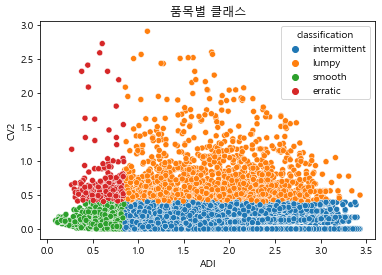

In [30]:
sns.scatterplot(x =np.log1p(segment.ADI), y = np.log1p(segment.CV2), hue = 'classification', data = segment )
plt.title('품목별 클래스')
#권역별로 품목의 판매 주기형태를 군집

In [31]:
segment.isna().sum()

고객사코드             0
품목코드              0
권역구분              0
CV2               0
ADI               0
classification    0
dtype: int64

### 3,4,5월 데이터 전처리 완성본

In [33]:
#segment = segment[['고객사코드','품목코드','권역구분','day_of_month', 'classification']]
segment

,고객사코드,품목코드,권역구분,CV2,ADI,classification
0,90001302,120941953_3,10,0.000000,7.818182,intermittent
1,90001302,120941953_3,12,0.109375,9.000000,intermittent
2,90001302,120941953_3,13,0.000000,12.333333,intermittent
3,90001302,120941953_3,17,0.000000,7.000000,intermittent
4,90001302,120941953_3,18,0.160000,16.000000,intermittent
...,...,...,...,...,...,...
17721,90001582,4789343708_4,44,0.130590,4.066667,intermittent
17722,90001582,4789343708_4,47,0.088296,3.588235,intermittent
17723,90001582,4789343708_4,58,0.238636,5.083333,intermittent
17724,90001582,4790583537_1,6,0.000000,4.571429,intermittent


In [34]:
final_345 = pd.merge(df_345_new, segment, how = 'left', on = ['고객사코드','품목코드','권역구분'])
final_345.sort_values(['고객사코드','품목코드','권역구분'], inplace = True)
#final_345.권역구분 = final_345.권역구분.astype(float)
final_345

,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month,CV,TO%,ABC,activate_days,CV2,ADI,classification
307917,KX007,90001302,120941953_3,1,10,5,1,2021-03-06,3,6,0.0,0.000835,A,0.0,0.0,7.818182,intermittent
307918,KX007,90001302,120941953_3,1,10,5,1,2021-03-13,3,13,0.0,0.000835,A,7.0,0.0,7.818182,intermittent
307919,KX007,90001302,120941953_3,1,10,4,0,2021-03-19,3,19,0.0,0.000835,A,6.0,0.0,7.818182,intermittent
307920,KX007,90001302,120941953_3,1,10,1,0,2021-03-23,3,23,0.0,0.000835,A,4.0,0.0,7.818182,intermittent
307921,KX007,90001302,120941953_3,1,10,3,0,2021-03-25,3,25,0.0,0.000835,A,2.0,0.0,7.818182,intermittent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405353,KX007,90001582,677756200_2,1,25,5,1,2021-04-24,4,24,0.0,0.000455,B,24.0,0.0,10.166667,intermittent
405354,KX007,90001582,677756200_2,1,25,5,1,2021-04-24,4,24,0.0,0.000455,B,0.0,0.0,10.166667,intermittent
405355,KX007,90001582,677756200_2,1,25,0,0,2021-04-26,4,26,0.0,0.000455,B,2.0,0.0,10.166667,intermittent
405356,KX007,90001582,677756200_2,1,25,0,0,2021-05-31,5,31,0.0,0.000455,B,35.0,0.0,10.166667,intermittent


In [35]:
final_345.isna().sum()

창고코드              0
고객사코드             0
품목코드              0
품목수량              0
권역구분              0
weekdays          0
holidays          0
date              0
month             0
day_of_month      0
CV                0
TO%               0
ABC               0
activate_days     0
CV2               0
ADI               0
classification    0
dtype: int64

* 품목수량의 이상치를 잘 잡아내기 위한 필터링 컬럼 생성

In [36]:
#final_345['per85'] = np.where(final_345.품목수량 > np.percentile(final_345.품목수량.values, 85), 1, 0)
final_345['per90'] = np.where(final_345.품목수량 > np.percentile(final_345.품목수량.values, 90), 1, 0)
final_345['per95'] = np.where(final_345.품목수량 > np.percentile(final_345.품목수량.values, 95), 1, 0)
final_345['per99'] = np.where(final_345.품목수량 > np.percentile(final_345.품목수량.values, 99), 1, 0)
final_345['per99.9'] = np.where(final_345.품목수량 > np.percentile(final_345.품목수량.values, 99.9), 1, 0)
final_345['per99.99'] = np.where(final_345.품목수량 > np.percentile(final_345.품목수량.values, 99.99), 1, 0)


In [37]:
np.percentile(final_345.품목수량.values, 90)

2.0

In [38]:
final_345['per90'].value_counts()

0    385074
1     21473
Name: per90, dtype: int64

In [39]:
final_345.isna().sum()

창고코드              0
고객사코드             0
품목코드              0
품목수량              0
권역구분              0
weekdays          0
holidays          0
date              0
month             0
day_of_month      0
CV                0
TO%               0
ABC               0
activate_days     0
CV2               0
ADI               0
classification    0
per90             0
per95             0
per99             0
per99.9           0
per99.99          0
dtype: int64

### 6월 데이터 전처리 완성본

In [40]:
df_6 = df_all[(df_all.month == 6)]


df_6_new = pd.merge(df_6, df_abc1, on = ['고객사코드','품목코드','권역구분'] )
df_6_new.drop([3,4,5,6], axis = 1, inplace = True)
df_6_new

,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month,CV,TO%,ABC
0,KX007,90001341,598604962-4,1,3,1,0,2021-06-01 00:00:00,6,1,0.342488,0.006600,A
1,KX007,90001341,598604962-4,1,3,1,0,2021-06-01 00:00:00,6,1,0.342488,0.006600,A
2,KX007,90001341,598604962-4,1,3,1,0,2021-06-01 00:00:00,6,1,0.342488,0.006600,A
3,KX007,90001341,598604962-4,1,3,3,0,2021-06-03 00:00:00,6,3,0.342488,0.006600,A
4,KX007,90001341,598604962-4,1,3,0,0,2021-06-07 00:00:00,6,7,0.342488,0.006600,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118125,KX007,90001582,4789343708_3,2,49,2,0,2021-06-16 00:00:00,6,16,0.000000,0.000379,B
118126,KX007,90001341,5256729806,1,53,2,0,2021-06-09 00:00:00,6,9,0.350671,0.001290,A
118127,KX007,90001341,5256729806,1,53,3,0,2021-06-10 00:00:00,6,10,0.350671,0.001290,A
118128,KX007,90001341,5256729806,1,53,4,0,2021-06-11 00:00:00,6,11,0.350671,0.001290,A


In [41]:
df_6_new.isna().sum()

창고코드            0
고객사코드           0
품목코드            0
품목수량            0
권역구분            0
weekdays        0
holidays        0
date            0
month           0
day_of_month    0
CV              0
TO%             0
ABC             0
dtype: int64

In [42]:
final_6 = pd.merge(df_6_new, segment, how = 'inner', on = ['고객사코드','품목코드','권역구분'])
final_6.sort_values(['date', '고객사코드','품목코드','권역구분'], inplace = True)
final_6

,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month,CV,TO%,ABC,CV2,ADI,classification
93782,KX007,90001302,120941953_3,1,31,1,0,2021-06-01 00:00:00,6,1,0.400000,0.000379,B,0.160000,15.250000,intermittent
86318,KX007,90001302,121016312,2,1,1,0,2021-06-01 00:00:00,6,1,0.000000,0.000228,B,0.000000,19.666667,intermittent
117116,KX007,90001302,121111509,2,8,1,0,2021-06-01 00:00:00,6,1,0.400000,0.000379,B,0.160000,13.000000,intermittent
110572,KX007,90001302,121144275,1,3,1,0,2021-06-01 00:00:00,6,1,0.000000,0.000303,B,0.000000,10.750000,intermittent
111547,KX007,90001302,121172041,3,5,1,0,2021-06-01 00:00:00,6,1,0.591485,0.001062,A,0.349854,7.625000,intermittent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117675,KX007,90001582,2049598779_4,1,11,2,0,2021-06-30 00:00:00,6,30,0.000000,0.000607,A,0.000000,7.625000,intermittent
117174,KX007,90001582,4288442391_1,1,18,2,0,2021-06-30 00:00:00,6,30,0.316200,0.002883,A,0.099983,1.666667,intermittent
117369,KX007,90001582,4288442391_2,1,14,2,0,2021-06-30 00:00:00,6,30,0.193863,0.003793,A,0.037583,1.145833,smooth
117423,KX007,90001582,4789343708_3,1,34,2,0,2021-06-30 00:00:00,6,30,0.000000,0.000759,A,0.000000,6.100000,intermittent


##### 3,4,5월의 각 고객사/품목/권역별로 평균적인 이상치  도출정도를 넣기 위해 생성

In [43]:
per = final_345.groupby(['고객사코드','품목코드','권역구분'])[['per90','per95','per99','per99.9','per99.99']].mean().reset_index()
per

,고객사코드,품목코드,권역구분,per90,per95,per99,per99.9,per99.99
0,90001302,120941953_3,10,0.000000,0.0,0.0,0.0,0.0
1,90001302,120941953_3,12,0.000000,0.0,0.0,0.0,0.0
2,90001302,120941953_3,13,0.000000,0.0,0.0,0.0,0.0
3,90001302,120941953_3,17,0.000000,0.0,0.0,0.0,0.0
4,90001302,120941953_3,18,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
17721,90001582,4789343708_4,44,0.000000,0.0,0.0,0.0,0.0
17722,90001582,4789343708_4,47,0.000000,0.0,0.0,0.0,0.0
17723,90001582,4789343708_4,58,0.083333,0.0,0.0,0.0,0.0
17724,90001582,4790583537_1,6,0.000000,0.0,0.0,0.0,0.0


In [44]:
final_6 = pd.merge(final_6, per, how = 'inner', on = ['고객사코드','품목코드','권역구분'])
final_6


,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month,...,TO%,ABC,CV2,ADI,classification,per90,per95,per99,per99.9,per99.99
0,KX007,90001302,120941953_3,1,31,1,0,2021-06-01 00:00:00,6,1,...,0.000379,B,0.160000,15.250000,intermittent,0.0,0.0,0.0,0.0,0.0
1,KX007,90001302,120941953_3,1,31,4,0,2021-06-04 00:00:00,6,4,...,0.000379,B,0.160000,15.250000,intermittent,0.0,0.0,0.0,0.0,0.0
2,KX007,90001302,120941953_3,1,31,6,1,2021-06-20 00:00:00,6,20,...,0.000379,B,0.160000,15.250000,intermittent,0.0,0.0,0.0,0.0,0.0
3,KX007,90001302,120941953_3,1,31,6,1,2021-06-27 00:00:00,6,27,...,0.000379,B,0.160000,15.250000,intermittent,0.0,0.0,0.0,0.0,0.0
4,KX007,90001302,121016312,2,1,1,0,2021-06-01 00:00:00,6,1,...,0.000228,B,0.000000,19.666667,intermittent,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118125,KX007,90001542,5450060354,1,12,2,0,2021-06-30 00:00:00,6,30,...,0.004097,A,0.034966,1.211538,smooth,0.0,0.0,0.0,0.0,0.0
118126,KX007,90001542,5450060354,1,27,2,0,2021-06-30 00:00:00,6,30,...,0.001214,A,0.058594,3.666667,intermittent,0.0,0.0,0.0,0.0,0.0
118127,KX007,90001542,5450060354,1,37,2,0,2021-06-30 00:00:00,6,30,...,0.001441,A,0.088296,3.117647,intermittent,0.0,0.0,0.0,0.0,0.0
118128,KX007,90001542,5450060354,1,37,2,0,2021-06-30 00:00:00,6,30,...,0.001441,A,0.088296,3.117647,intermittent,0.0,0.0,0.0,0.0,0.0


In [45]:
final_345.columns.isin(final_6.columns)



array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True])

In [46]:
final_6.isna().sum()

창고코드              0
고객사코드             0
품목코드              0
품목수량              0
권역구분              0
weekdays          0
holidays          0
date              0
month             0
day_of_month      0
CV                0
TO%               0
ABC               0
CV2               0
ADI               0
classification    0
per90             0
per95             0
per99             0
per99.9           0
per99.99          0
dtype: int64

### 최종 모델링 데이터 생성

*  activate_days변수는 6월 데이터에서 알 수 없기에 사용 x

In [47]:
final = pd.concat([final_345.drop('activate_days', axis = 1),final_6], axis = 0)
final

,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month,...,TO%,ABC,CV2,ADI,classification,per90,per95,per99,per99.9,per99.99
307917,KX007,90001302,120941953_3,1,10,5,1,2021-03-06 00:00:00,3,6,...,0.000835,A,0.000000,7.818182,intermittent,0.0,0.0,0.0,0.0,0.0
307918,KX007,90001302,120941953_3,1,10,5,1,2021-03-13 00:00:00,3,13,...,0.000835,A,0.000000,7.818182,intermittent,0.0,0.0,0.0,0.0,0.0
307919,KX007,90001302,120941953_3,1,10,4,0,2021-03-19 00:00:00,3,19,...,0.000835,A,0.000000,7.818182,intermittent,0.0,0.0,0.0,0.0,0.0
307920,KX007,90001302,120941953_3,1,10,1,0,2021-03-23 00:00:00,3,23,...,0.000835,A,0.000000,7.818182,intermittent,0.0,0.0,0.0,0.0,0.0
307921,KX007,90001302,120941953_3,1,10,3,0,2021-03-25 00:00:00,3,25,...,0.000835,A,0.000000,7.818182,intermittent,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118125,KX007,90001542,5450060354,1,12,2,0,2021-06-30 00:00:00,6,30,...,0.004097,A,0.034966,1.211538,smooth,0.0,0.0,0.0,0.0,0.0
118126,KX007,90001542,5450060354,1,27,2,0,2021-06-30 00:00:00,6,30,...,0.001214,A,0.058594,3.666667,intermittent,0.0,0.0,0.0,0.0,0.0
118127,KX007,90001542,5450060354,1,37,2,0,2021-06-30 00:00:00,6,30,...,0.001441,A,0.088296,3.117647,intermittent,0.0,0.0,0.0,0.0,0.0
118128,KX007,90001542,5450060354,1,37,2,0,2021-06-30 00:00:00,6,30,...,0.001441,A,0.088296,3.117647,intermittent,0.0,0.0,0.0,0.0,0.0


In [48]:
final2 = final

In [49]:
final.isna().sum()

창고코드              0
고객사코드             0
품목코드              0
품목수량              0
권역구분              0
weekdays          0
holidays          0
date              0
month             0
day_of_month      0
CV                0
TO%               0
ABC               0
CV2               0
ADI               0
classification    0
per90             0
per95             0
per99             0
per99.9           0
per99.99          0
dtype: int64

##### 품목에 대한 값 추가 및 one-hot Encoding

In [50]:
final = pd.get_dummies(final, columns = ['weekdays'], prefix = 'weekday')
final = pd.get_dummies(final, columns = ['고객사코드'], prefix = '고객사코드')
final = pd.get_dummies(final, columns = ['day_of_month'], prefix = '일')
final = pd.get_dummies(final, columns = ['classification'], prefix = '클래스')
final = pd.get_dummies(final, columns = ['권역구분'], prefix = '권역')
final = pd.get_dummies(final, columns = ['ABC'], prefix = 'abc')


In [51]:
pd.options.display.max_columns = 50
pd.options.display.max_columns = 100

In [52]:
final[sorted(final.columns)] 

,ADI,CV,CV2,TO%,abc_A,abc_B,date,holidays,month,per90,per95,per99,per99.9,per99.99,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,고객사코드_90001302,고객사코드_90001341,고객사코드_90001441,고객사코드_90001443,고객사코드_90001521,고객사코드_90001541,고객사코드_90001542,고객사코드_90001582,권역_1,권역_10,권역_11,권역_12,권역_13,권역_14,권역_15,권역_16,권역_17,권역_18,권역_2,권역_21,권역_22,권역_24,권역_25,권역_26,권역_27,권역_28,권역_29,권역_3,권역_30,...,권역_55,권역_56,권역_57,권역_58,권역_59,권역_6,권역_61,권역_62,권역_63,권역_7,권역_8,권역_99,일_1,일_10,일_11,일_12,일_13,일_14,일_15,일_16,일_17,일_18,일_19,일_2,일_20,일_21,일_22,일_23,일_24,일_25,일_26,일_27,일_28,일_29,일_3,일_30,일_31,일_4,일_5,일_6,일_7,일_8,일_9,창고코드,클래스_erratic,클래스_intermittent,클래스_lumpy,클래스_smooth,품목수량,품목코드
307917,7.818182,0.000000,0.000000,0.000835,1,0,2021-03-06 00:00:00,1,3,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,KX007,0,1,0,0,1,120941953_3
307918,7.818182,0.000000,0.000000,0.000835,1,0,2021-03-13 00:00:00,1,3,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,KX007,0,1,0,0,1,120941953_3
307919,7.818182,0.000000,0.000000,0.000835,1,0,2021-03-19 00:00:00,0,3,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,KX007,0,1,0,0,1,120941953_3
307920,7.818182,0.000000,0.000000,0.000835,1,0,2021-03-23 00:00:00,0,3,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,KX007,0,1,0,0,1,120941953_3
307921,7.818182,0.000000,0.000000,0.000835,1,0,2021-03-25 00:00:00,0,3,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,KX007,0,1,0,0,1,120941953_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118125,1.211538,0.186992,0.034966,0.004097,1,0,2021-06-30 00:00:00,0,6,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,KX007,0,0,0,1,1,5450060354
118126,3.666667,0.242061,0.058594,0.001214,1,0,2021-06-30 00:00:00,0,6,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,KX007,0,1,0,0,1,5450060354
118127,3.117647,0.297147,0.088296,0.001441,1,0,2021-06-30 00:00:00,0,6,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,KX007,0,1,0,0,1,5450060354
118128,3.117647,0.297147,0.088296,0.001441,1,0,2021-06-30 00:00:00,0,6,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,KX007,0,1,0,0,1,5450060354


In [53]:
품v = pd.DataFrame(final2.groupby(['classification'])['품목수량'].sum()).reset_index()

품v

,classification,품목수량
0,erratic,57231
1,intermittent,368826
2,lumpy,101098
3,smooth,169484


## Train/Test 셋 생성

In [54]:
train = final[final.month != 6]
test = final[final.month == 6]

#### 스케일링에 따른 각 독립변수의 분포 형태를 확인 후, 적절한 스케일링 채택

C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='ADI', ylabel='Density'>

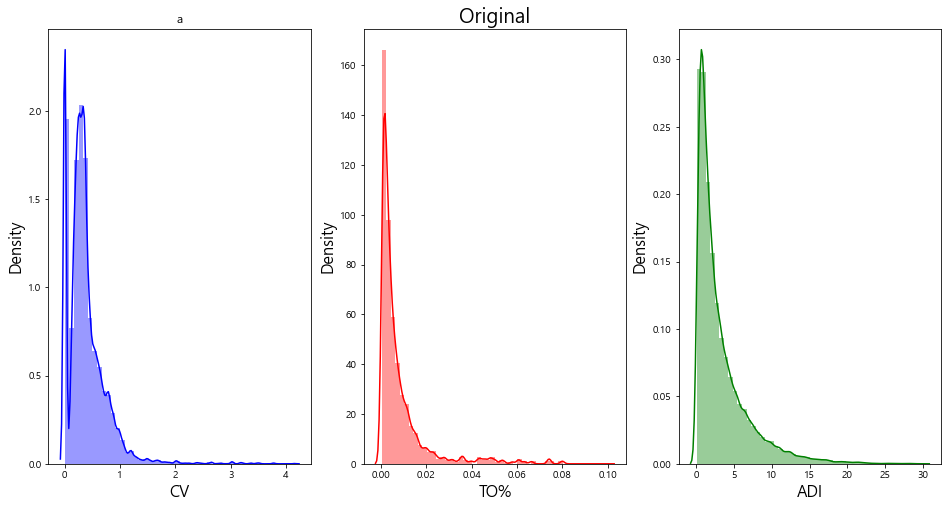

In [233]:
fig = plt.figure(figsize = (16,8))

var_color_dict = {'CV': 'blue', 

                      'TO%': 'red', 

                      'ADI': 'green'}


ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


X = train[['CV','TO%','ADI', '품목수량']]

ax2.set_title('Original')
ax2.title.set_size(20)

ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)

ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

ax3.xaxis.label.set_size(16)
ax3.yaxis.label.set_size(16)


sns.distplot(X['CV'],
             color = var_color_dict['CV'],
             ax = ax1)
ax1.set_title('a')
sns.distplot(X['TO%'],
             color = var_color_dict['TO%'],
             ax = ax2)
sns.distplot(X['ADI'],
             color = var_color_dict['ADI'],
             ax = ax3)


C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='ADI', ylabel='Density'>

C:\Users\tjddl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tjddl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


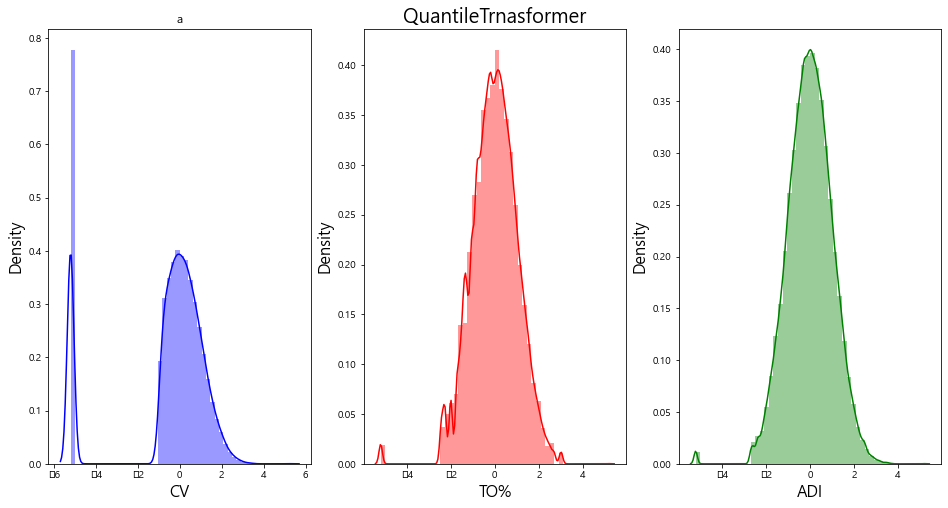

In [234]:
fig = plt.figure(figsize = (16,8))

var_color_dict = {'CV': 'blue', 

                      'TO%': 'red', 

                      'ADI': 'green'}


ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


X = train[['CV','TO%','ADI']]
X_trans = QuantileTransformer(n_quantiles=5000, output_distribution='normal').fit_transform(X)
X= pd.DataFrame(X_trans, columns = ['CV','TO%','ADI'])

ax2.set_title('QuantileTrnasformer')
ax2.title.set_size(20)

ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)

ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

ax3.xaxis.label.set_size(16)
ax3.yaxis.label.set_size(16)


sns.distplot(X['CV'],
             color = var_color_dict['CV'],
             ax = ax1)
ax1.set_title('a')
sns.distplot(X['TO%'],
             color = var_color_dict['TO%'],
             ax = ax2)
sns.distplot(X['ADI'],
             color = var_color_dict['ADI'],
             ax = ax3)

C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='ADI', ylabel='Density'>

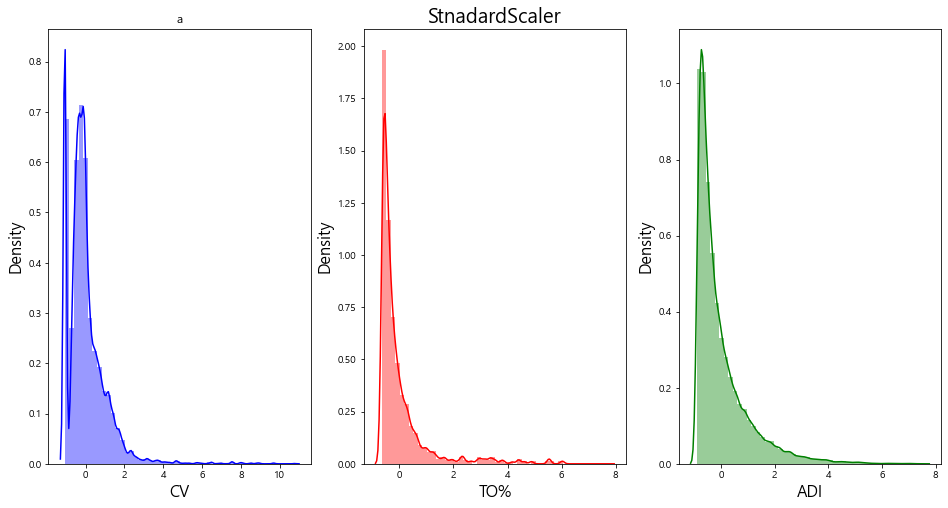

In [235]:
#########################################################


fig = plt.figure(figsize = (16,8))

var_color_dict = {'CV': 'blue', 

                      'TO%': 'red', 

                      'ADI': 'green'}


ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


X = train[['CV','TO%','ADI']]
X_trans = StandardScaler().fit_transform(X)
X = pd.DataFrame(X_trans, columns = ['CV','TO%','ADI'])

ax2.set_title('StnadardScaler')
ax2.title.set_size(20)

ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)

ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

ax3.xaxis.label.set_size(16)
ax3.yaxis.label.set_size(16)


sns.distplot(X['CV'],
             color = var_color_dict['CV'],
             ax = ax1)
ax1.set_title('a')
sns.distplot(X['TO%'],
             color = var_color_dict['TO%'],
             ax = ax2)
sns.distplot(X['ADI'],
             color = var_color_dict['ADI'],
             ax = ax3)

C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='ADI', ylabel='Density'>

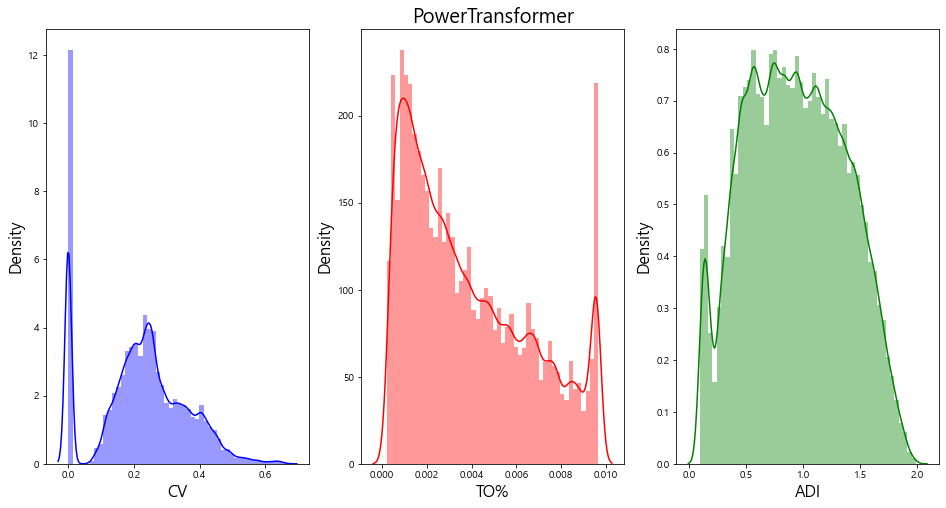

In [236]:
#########################################################


fig = plt.figure(figsize = (16,8))

var_color_dict = {'CV': 'blue', 

                      'TO%': 'red', 

                      'ADI': 'green'}


ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


X = train[['CV','TO%','ADI']]
X_trans = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(X)
X = pd.DataFrame(X_trans, columns = ['CV','TO%','ADI'])



ax2.set_title('PowerTransformer')
ax2.title.set_size(20)

ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)

ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

ax3.xaxis.label.set_size(16)
ax3.yaxis.label.set_size(16)

sns.distplot(X['CV'],
             color = var_color_dict['CV'],
             ax = ax1)

sns.distplot(X['TO%'],
             color = var_color_dict['TO%'],
             ax = ax2)
sns.distplot(X['ADI'],
             color = var_color_dict['ADI'],
             ax = ax3)

* 연속형 변수에 대해 정규분포와 근사하게 만들어주는 QuantileTransformer스케일링 채택

### 필요한 독립변수 채택 및 데이터셋 분할

In [267]:
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal')

cols = [col for col in train.columns if col not in ['date', "품목수량", 'month', '품목코드',
                                                    '품목금액','창고코드', 'weekday_5', 'weekday_6',
                                                   'CV2','품목수량_mean','품목수량_std', 'holidays',
                                                   'activate_days_std','ABC']]
X_train = train[cols]
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

#데이터의 분포를 모았을 때 밀집되어 있는 부분은 퍼지게, 퍼져있는 부분은 모아지게 만든다.
#로그 스케일 및 데이터 자체의 스케일을 고려하여 y_train만 로그변화를 해야한다고 판단
y_train = np.log1p(train['품목수량'])


X_test = test[cols]
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

y_test = test['품목수량']


In [268]:
print(X_train.shape, X_test.shape)

(406547, 115) (118130, 115)


### 독립변수의 통계적 유의성 검증

In [291]:
import statsmodels.api as sm

fullModel = sm.OLS(y_train,X_train)
fittedFullModel = fullModel.fit()
 
#R-Squre 가 높고 , 대부분의 변수들이 유의함.
print(fittedFullModel.summary())

                            OLS Regression Results                            
Dep. Variable:                   품목수량   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                 1.532e+04
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:27:31   Log-Likelihood:             2.9728e+05
No. Observations:              406547   AIC:                        -5.943e+05
Df Residuals:                  406435   BIC:                        -5.931e+05
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
CV                   0.0525      0.001  

### 일반적인 회귀의 성능

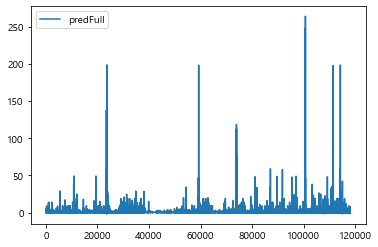

5.741242726575892


In [126]:
predY2 = fittedFullModel.predict(X_test)
 
plt.plot(np.array(y_test-predY2),label="predFull")
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true=y_test,y_pred=predY2)
print(MSE)

###  Grid SearchCV 함수 생성

In [264]:
def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=10,
        scoring='neg_mean_squared_error')

    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 10 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(
            model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

## 모델링 (XGboost)

In [297]:
xgb_model = XGBRegressor()

In [298]:
print(xgb_model)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


#### Tree Booster를 사용하기 위해서는 세 가지 유형의 파라미터를 설정해야 한다.

* General parameter  : 일반적으로 트리 또는 선형 모델에서 부스팅을 수행하는 데 사용하는 부스터와 관련된 파라미터이다.
* Booster parameter : 선택한 부스터의 파라미터에 따라 다름. 
* Learning task parameter : 학습 시나리오를 결정한다. Regression은 Ranking 같은 파라미터와 다른 것들을 함께 사용할 수 있다.

In [312]:
xgb_params = {
    'booster' : ['dart'], # [gbtree, gblinear, dart] 
    'learning_rate' : [0.02, 0.01],
    'n_estimators':[300, 500],
    'max_depth' :[-1],
    'subsample': [0.01, 0.005],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha' : [0.2]
    ## 불균형한 경우 더 빠른 수렴(convergence)에 도움되므로 0보다 큰 값을 쓸것.
}


xgb_model = XGBRegressor()
xgb_estimator = print_best_params(xgb_model, xgb_params)

XGBRegressor 10 CV 시 최적 평균 RMSE 값 0.1166, 최적 alpha:{'booster': 'gbtree', 'colsample_bytree': 0.7, 'learning_rate': 0.02, 'n_estimators': 500, 'reg_alpha': 0.2, 'scale_pos_weight': 0.6, 'subsample': 0.005}


### RMSE 도출

In [573]:
xgb_preds = xgb_estimator.predict(X_test_scaled)
rmse_xgb = np.sqrt(mean_squared_error(y_test,xgb_preds))
print("XGBRegressor test RMSE: %f" % (rmse_xgb ))

XGBRegressor test RMSE: 2.334536


### 변수별 중요도 관찰 (이후 중요도를 기준으로 최적의 독릭변수 선택)

Text(0.5, 0, 'XGBRegressor Feature Importance')

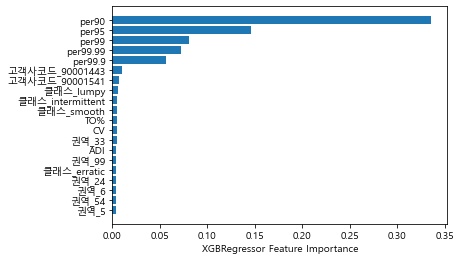

In [626]:
sorted_idx = xgb_estimator.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-20:], xgb_estimator.feature_importances_[sorted_idx][-20:])
plt.xlabel("XGBRegressor Feature Importance")

In [633]:
pd.DataFrame(xgb_estimator.feature_importances_, X_train.columns).sort_values(0, ascending = False)

,0
per90,0.335715
per95,0.145626
per99,0.080943
per99.99,0.072212
per99.9,0.056625
...,...
고객사코드_90001582,0.000569
권역_45,0.000000
권역_29,0.000000
권역_43,0.000000


## 모델링 (ExtraTrees)

In [301]:
ext_model.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [310]:
ext_params= {
    'n_estimators': [100,200],
    'criterion': ['mse'],
    'min_samples_split': [6,10],
    'min_samples_leaf': [5,10],
    'oob_score': [True], 
    'bootstrap' : [True],
    'warm_start': [True],
    'n_jobs' : [-1]
}

ext_model = ExtraTreesRegressor()
ext_estimator = print_best_params(ext_model, ext_params)

ExtraTreesRegressor 10 CV 시 최적 평균 RMSE 값 0.1148, 최적 alpha:{'bootstrap': True, 'criterion': 'mse', 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': True, 'warm_start': True}


### RMSE 도출

In [572]:
### RMSE 도출ext_preds = ext_estimator.predict(X_test_scaled)
rmse_ext = np.sqrt(mean_squared_error(y_test,ext_preds))
print("ExtraTreesRegressor test RMSE: %f" % (rmse_xgb ))

 ExtraTreesRegressor test RMSE: 2.334536


### 변수별 중요도 관찰 (이후 중요도를 기준으로 최적의 독릭변수 선택)

Text(0.5, 0, 'ExtraTreesRegressor Feature Importance')

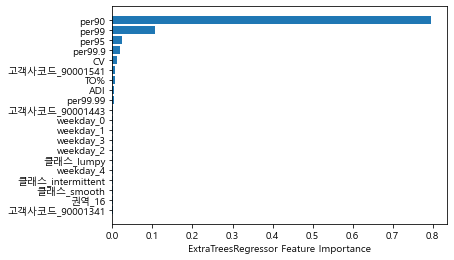

In [625]:
sorted_idx = ext_estimator.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-20:], ext_estimator.feature_importances_[sorted_idx][-20:])
plt.xlabel("ExtraTreesRegressor Feature Importance")

In [621]:
ext_estimator.feature_importances_.dtype

dtype('float64')

## 모델링 (LGBM Regressor)

In [55]:
lgb_set = final2[['고객사코드','품목코드','품목수량','weekdays','day_of_month','TO%','CV2','ADI','classification','month','holidays','per90','per95','per99','per99.9','ABC']]

In [56]:
lgb_set['고객사코드'] = lgb_set['고객사코드'].astype('category')
lgb_set['품목코드'] = lgb_set['품목코드'].astype('category')
lgb_set['weekdays'] = lgb_set['weekdays'].astype('category')
lgb_set['holidays'] = lgb_set['holidays'].astype('category')
lgb_set['day_of_month'] = lgb_set['day_of_month'].astype('category')
lgb_set['classification'] = lgb_set['classification'].astype('category')
lgb_set['ABC'] = lgb_set['ABC'].astype('category')

C:\Users\tjddl\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\tjddl\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tjddl\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [57]:
lgb_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524677 entries, 307917 to 118129
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   고객사코드           524677 non-null  category
 1   품목코드            524677 non-null  category
 2   품목수량            524677 non-null  int64   
 3   weekdays        524677 non-null  category
 4   day_of_month    524677 non-null  category
 5   TO%             524677 non-null  float64 
 6   CV2             524677 non-null  float64 
 7   ADI             524677 non-null  float64 
 8   classification  524677 non-null  category
 9   month           524677 non-null  int64   
 10  holidays        524677 non-null  category
 11  per90           524677 non-null  float64 
 12  per95           524677 non-null  float64 
 13  per99           524677 non-null  float64 
 14  per99.9         524677 non-null  float64 
 15  ABC             524677 non-null  category
dtypes: category(7), float64(7), int64

In [58]:
lgb_train_x = lgb_set[lgb_set.month != 6]
lgb_train_y = lgb_train_x.pop('품목수량')
lgb_test_x = lgb_set[lgb_set.month == 6]
lgb_test_y = lgb_test_x.pop('품목수량')

In [59]:
lgb_train_x.drop(['month'], axis = 1, inplace = True)
lgb_test_x.drop(['month'], axis = 1, inplace = True)

C:\Users\tjddl\anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [60]:
lgb_train_x.shape

(406547, 14)

In [61]:
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal')



scaler.fit(lgb_train_x[['CV2','TO%','ADI']])
lgb_train_x_scaled = pd.DataFrame(scaler.fit_transform(lgb_train_x[['CV2','TO%','ADI']]), 
                              columns = [['CV2','TO%','ADI']])

lgb_train_x[['CV2','TO%','ADI']] = lgb_train_x_scaled


#데이터의 분포를 모았을 때 밀집되어 있는 부분은 퍼지게, 퍼져있는 부분은 모아지게 만든다.
#로그 스케일 및 데이터 자체의 스케일을 고려하여 y_train만 로그변화를 해야한다고 판단

#lgb_train_y = np.log1p(lgb_train_y)


lgb_test_x_scaled = pd.DataFrame(scaler.fit_transform(lgb_test_x[['CV2','TO%','ADI']]), columns = [['CV2','TO%','ADI']])

lgb_test_x[['CV2','TO%','ADI']] = lgb_test_x_scaled



C:\Users\tjddl\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\tjddl\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [62]:
def print_best_params_lgb(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=10,
        scoring='neg_mean_squared_error')

    grid_model.fit(lgb_train_x, lgb_train_y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(
        '{0} 10 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(
            model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [63]:
LGBMRegressor().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
lgb_params = {
    'objective':['regression'],
    'boosting_type': ['dart'],
    'num_leaves' : [100, 200, 300, 400],
    # 과적합을 방지하기 위해 num_leaves는 2^(max_depth)보다 작아야 한다. 
    # 예를 들어 max_depth가 7이기 때문에, 2^(max_depth)=128이 되는데, 이 때 num_leaves를 이보다 작은 70~80 정도로 설정하는 것이 낫다.
    'learning_rate' : [0.05, 0.02, 0.01],
    'n_estimators':[300,500],
    'max_depth' :[10,20,30],
    'subsample': [0.001, 0.0005],
    'colsample_bytree': [0.7, 1], #최적
    'reg_alpha' : [0,1, 0.2, 0.3]
}


lgb_model = LGBMRegressor()
lgb_estimator = print_best_params_lgb(lgb_model, lgb_params)

In [561]:
lgb_estimator.set_params()

LGBMRegressor(boosting_type='dart', colsample_bytree=0.7, learning_rate=0.05,
              n_estimators=500, objective='regression', reg_alpha=0.3,
              subsample=0.001)

In [ ]:
lgb_preds = lgb_estimator.predict(lgb_test_x)
rmse_lgb = np.sqrt(mean_squared_error(lgb_test_y,lgb_preds))
print("LGBRegressor test RMSE: %f" % (rmse_lgb ))

### RMSE 도출

In [570]:
### RMSE 도출lgb_preds = lgb_estimator.predict(lgb_test_x)
rmse_lgb = np.sqrt(mean_squared_error(lgb_test_y,lgb_preds))
print("LGBRegressor test RMSE: %f" % (rmse_lgb ))

LGBRegressor test RMSE: 2.262533


### 변수별 중요도 관찰 (이후 중요도를 기준으로 최적의 독릭변수 선택)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

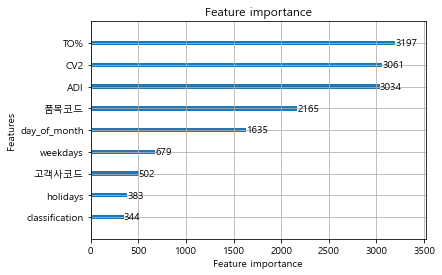

In [588]:
plot_importance(lgb_estimator, max_num_features = 20)

### 전 권역을 통틀어 순수 품목만의 품목수량 실제값과 예측값을 비교해보자

In [282]:
train_set = final2[final2.month != 6]



train_set = train_set[['date','고객사코드','품목코드','품목수량']]
train_set.sort_values('date', inplace = True)

train_set = train_set.groupby(['date','고객사코드','품목코드'])['품목수량'].sum().reset_index()
train_set

,date,고객사코드,품목코드,품목수량
0,2021-03-01,90001302,121016312,1
1,2021-03-01,90001302,121111509,2
2,2021-03-01,90001302,121174426_1,2
3,2021-03-01,90001302,121174432_7,2
4,2021-03-01,90001302,121174437_2,15
...,...,...,...,...
47102,2021-05-31,90001582,4789343708_1,2
47103,2021-05-31,90001582,4789343708_2,3
47104,2021-05-31,90001582,4789343708_3,10
47105,2021-05-31,90001582,4789343708_4,33


In [562]:
test_set = final2[final2.month == 6]

lgb_preds = np.round(lgb_preds)


test_set = test_set[['date','고객사코드','품목코드','품목수량']]
test_set = pd.concat([test_set,pd.DataFrame(lgb_preds)], axis = 1)

test_set.rename(columns = {0 : 'pred'}, inplace = True)
test_set = test_set.groupby(['date','고객사코드','품목코드'])[['품목수량','pred']].sum().reset_index()
test_set['diff'] = np.abs(test_set['품목수량'] - test_set['pred'])

In [563]:
set_345 = train_set
set_6 = test_set

set_345.to_csv('D:\\NIA\\선택과제\\2021년_미래기술_챌린지_211002\\1. 이커머스 FC주문 데이터\\set_345.csv')
set_6.to_csv('D:\\NIA\\선택과제\\2021년_미래기술_챌린지_211002\\1. 이커머스 FC주문 데이터\\set_6.csv')


In [564]:
#품목별 예측값 RMSE
asd = np.sqrt(mean_squared_error(test_set.품목수량,test_set.pred))
print(" RMSE: %f" % (asd ))

 RMSE: 7.561409


In [565]:
print(np.percentile(train_set.품목수량.values, 99))
print(np.percentile(test_set.품목수량.values, 99))
print(np.percentile(test_set.pred.values, 99))

112.0
99.0
96.0


### 일별 전체 품목수량 실제값 예측값 비교

Text(0.5, 1.0, '6월 일별 실제/예측 품목수량')

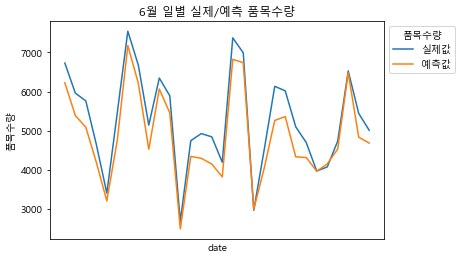

In [566]:
sns.lineplot(x='date',y='품목수량',data=test_set.groupby(['date'])['품목수량'].sum().reset_index())
sns.lineplot(x='date',y='pred',data=test_set.groupby(['date'])['pred'].sum().reset_index())
plt.legend(labels=["실제값","예측값"], title = "품목수량", loc = 2, bbox_to_anchor = (1,1))
plt.xticks([])
plt.title('6월 일별 실제/예측 품목수량')

### 특정 품목코드 4개의 실제값과 예측값 비교 

Text(0.5, 1.0, '품목코드 5184904828')

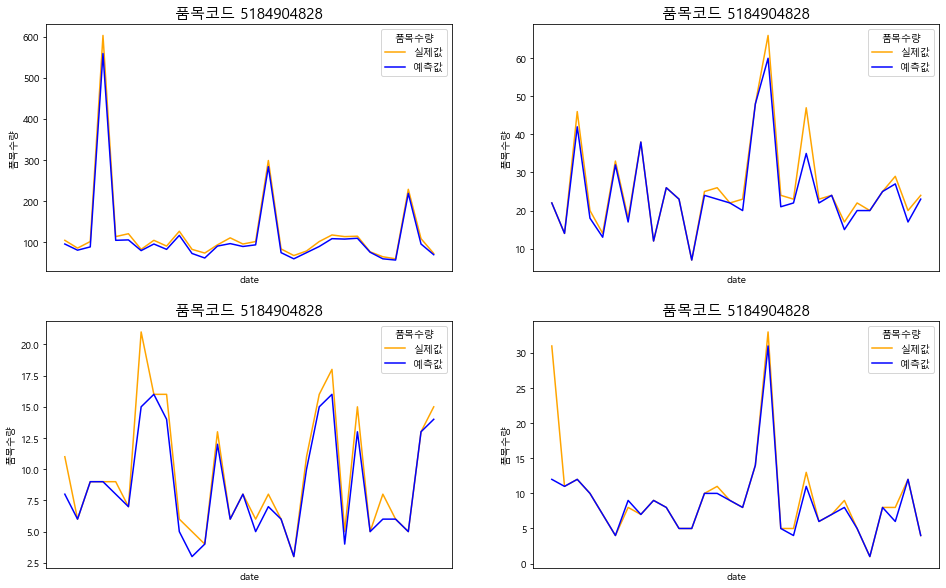

In [567]:
fig = plt.figure(figsize = (16,10))

ax1 = fig.add_subplot(2,2,1)

ax1 = sns.lineplot(x='date',y='품목수량',data=test_set[test_set.품목코드 == '5184904828'],
                  color = 'orange')
ax1 = sns.lineplot(x='date',y='pred',data=test_set[test_set.품목코드 == '5184904828'],
                  color = 'blue')

plt.legend(labels=["실제값","예측값"], title = "품목수량", loc = 1)
           #bbox_to_anchor = (1,1))
ax1.axes.xaxis.set_ticks([])
plt.title('품목코드 5184904828', fontsize = 15 )

ax2 = fig.add_subplot(2,2,2)

ax2 = sns.lineplot(x='date',y='품목수량',data=test_set[test_set.품목코드 == '477612946'],
                  color = 'orange')
ax2 = sns.lineplot(x='date',y='pred',data=test_set[test_set.품목코드 == '477612946'],
                  color = 'blue')

plt.legend(labels=["실제값","예측값"], title = "품목수량", loc = 1)
           #bbox_to_anchor = (1,1))
ax2.axes.xaxis.set_ticks([])
plt.title('품목코드 5184904828', fontsize = 15 )


ax3 = fig.add_subplot(2,2,3)

ax3 = sns.lineplot(x='date',y='품목수량',data=test_set[test_set.품목코드 == '4824061918_22'],
                  color = 'orange')
ax3 = sns.lineplot(x='date',y='pred',data=test_set[test_set.품목코드 == '4824061918_22'],
                  color = 'blue')

plt.legend(labels=["실제값","예측값"], title = "품목수량", loc = 1)
           #bbox_to_anchor = (1,1))
#plt.xticks(rotation=90)
ax3.axes.xaxis.set_ticks([])

plt.title('품목코드 5184904828', fontsize = 15 )

ax4 = fig.add_subplot(2,2,4)

ax4 = sns.lineplot(x='date',y='품목수량',data=test_set[test_set.품목코드 == '4810960248-3'],
                  color = 'orange')
ax4 = sns.lineplot(x='date',y='pred',data=test_set[test_set.품목코드 == '4810960248-3'],
                  color = 'blue')

plt.legend(labels=["실제값","예측값"], title = "품목수량", loc = 1)
           #bbox_to_anchor = (1,1))
#plt.xticks(rotation=90)
ax4.axes.xaxis.set_ticks([])
plt.title('품목코드 5184904828', fontsize = 15 )


### 각 품목코드에 대한 품목수량 관측값과 예측값의 차이 관찰

In [360]:
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted_count'] = pred
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending = True)[:n_tops])
    

get_top_error_data(test_set.품목수량, test_set.pred, n_tops = 1000)

       real_count  predicted_count  diff
0               1              1.0   0.0
8660            2              2.0   0.0
8661            3              3.0   0.0
8662            3              3.0   0.0
8665           14             14.0   0.0
...           ...              ...   ...
10193           4              4.0   0.0
10191           1              1.0   0.0
10156           4              4.0   0.0
10158           1              1.0   0.0
10159           1              1.0   0.0

[1000 rows x 3 columns]
